In [69]:
import torch
from tqdm import tqdm
import copy
import numpy as np
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, average_precision_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = torch.load('./data/github_full_data.pt')
data_sub = torch.load('./data/github_sub_data.pt')

print(data)
print(data_sub)

Data(x=[37700, 512], edge_index=[2, 578006])
Data(x=[4965, 512], edge_index=[2, 37094])


In [70]:
transform = T.Compose([T.RandomLinkSplit(num_val=0.10, num_test=0.20, neg_sampling_ratio = 1.0, is_undirected=True, add_negative_train_samples=False, disjoint_train_ratio= 0)])

train_data, val_data, test_data = transform(data_sub)
print(train_data)
print(val_data)
print(test_data)

Data(x=[4965, 512], edge_index=[2, 25968], edge_label=[12984], edge_label_index=[2, 12984])
Data(x=[4965, 512], edge_index=[2, 25968], edge_label=[3708], edge_label_index=[2, 3708])
Data(x=[4965, 512], edge_index=[2, 29676], edge_label=[7418], edge_label_index=[2, 7418])


In [71]:
print("Val positives:", (val_data.edge_label==1).sum().item(), 
      "negatives:", (val_data.edge_label==0).sum().item())
print("Test positives:", (test_data.edge_label==1).sum().item(), 
      "negatives:", (test_data.edge_label==0).sum().item())

Val positives: 1854 negatives: 1854
Test positives: 3709 negatives: 3709


In [72]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers = 3, dropout = 0.5):
        super(GCN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
          self.convs.append(GCNConv(hidden_dim,hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])
        self.drops = nn.ModuleList([nn.Dropout(dropout) for _ in range(num_layers - 1)])

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):

        h = x

        for i in range(len(self.convs) - 1):
            h = self.convs[i](h, edge_index)
            h = self.bns[i](h)
            h = F.relu(h)
            h = self.drops[i](h)

        out = self.convs[-1](h, edge_index)

        return out

In [73]:
class DotProductPredictor(nn.Module):
    def forward(self, out, edge_label_index):
        src = edge_label_index[0]
        dst = edge_label_index[1]
        return (out[src] * out[dst]).sum(dim=-1)

In [74]:
class HadamardMLPPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def reset_parameters(self):
        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def forward(self, out, edge_label_index):
        src = edge_label_index[0]
        dst = edge_label_index[1]
        # Element-wise product (Hadamard)
        h = out[src] * out[dst]
        return self.mlp(h).view(-1)

In [75]:
class ConcatMLPPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def reset_parameters(self):
        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def forward(self, out, edge_label_index):
        src = edge_label_index[0]
        dst = edge_label_index[1]
        # Concatenate embeddings
        h = torch.cat([out[src], out[dst]], dim=-1)
        return self.mlp(h).view(-1)

In [76]:
def train(model, train_data, optimizer, predictor, loss_fn="bce", num_negatives=1):
    model.train()
    optimizer.zero_grad()
    pos_edge_index = train_data.edge_label_index.to(device)
    out = model(train_data.x, train_data.edge_index)

    if loss_fn == "bce":
        pos_label = torch.ones(pos_edge_index.size(1), device=out.device)
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index,
            num_nodes=train_data.num_nodes,
            num_neg_samples=pos_edge_index.size(1)
        ).to(device)
        neg_label = torch.zeros(neg_edge_index.size(1), device=out.device)
        edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        edge_label = torch.cat([pos_label, neg_label], dim=0)
        score = predictor(out, edge_label_index).view(-1)
        loss = F.binary_cross_entropy_with_logits(score, edge_label)

    elif loss_fn == "bpr":
        num_pos = pos_edge_index.size(1)
        src = pos_edge_index[0].repeat_interleave(num_negatives)  # [num_pos * num_negatives]
        # 采样 K 个负节点，每个正样本一组
        neg_dst = torch.randint(
            0, train_data.num_nodes,
            (num_pos * num_negatives,),
            device=out.device
        )
        neg_edge_index = torch.stack([src, neg_dst], dim=0)  # [2, num_pos * num_negatives]
        # 正样本得分扩展 K 倍（每个正样本复制 K 次，与负样本一一对应）
        score_pos = predictor(out, pos_edge_index).view(-1).repeat_interleave(num_negatives)
        score_neg = predictor(out, neg_edge_index).view(-1)
        loss = -torch.log(torch.sigmoid(score_pos - score_neg) + 1e-8).mean()

    else:
        raise ValueError("Unknown loss_fn type: choose 'bce' or 'bpr'.")

    loss.backward()
    optimizer.step()
    return loss.item()


In [77]:
@torch.no_grad()
def test(model, data, predictor, K=10, num_neg_per_pos=100, max_eval=None):
    """
    评测链路预测：per-source Hit@K, MRR + 全局AUC, AP
    """
    model.eval()
    out = model(data.x, data.edge_index)
    device = out.device

    # ========== 1. 计算全局 AUC/AP ==========
    # 对data.edge_label_index的所有边打分
    all_score = predictor(out, data.edge_label_index).cpu().numpy()
    all_label = data.edge_label.cpu().numpy()
    auc = roc_auc_score(all_label, all_score)
    ap = average_precision_score(all_label, all_score)

    # ========== 2. per-source Hit@K, MRR ==========
    pos_mask = data.edge_label == 1
    src_nodes = data.edge_label_index[0][pos_mask].cpu().numpy()
    tgt_nodes = data.edge_label_index[1][pos_mask].cpu().numpy()
    num_nodes = data.num_nodes

    hit_list, mrr_list = [], []
    existing_edges = set((u.item(), v.item()) for u, v in zip(data.edge_index[0], data.edge_index[1]))

    eval_indices = range(len(src_nodes))
    if max_eval is not None and max_eval < len(src_nodes):
        eval_indices = np.random.choice(len(src_nodes), max_eval, replace=False)

    for idx in tqdm(eval_indices, desc="Evaluating"):
        src = int(src_nodes[idx])
        tgt = int(tgt_nodes[idx])
        # 采样负样本（排除已连边和正样本自己）
        neg_tgts = set()
        while len(neg_tgts) < num_neg_per_pos:
            neg_cand = np.random.randint(0, num_nodes)
            if (src, neg_cand) in existing_edges: continue
            if neg_cand == tgt: continue
            neg_tgts.add(neg_cand)
        all_tgts = [tgt] + list(neg_tgts)
        edge_idx = torch.tensor([[src] * len(all_tgts), all_tgts], dtype=torch.long, device=device)
        scores = predictor(out, edge_idx).cpu().numpy()
        rank_order = (-scores).argsort()
        rank_pos = np.where(rank_order == 0)[0][0]
        hit_list.append(rank_pos < K)
        mrr_list.append(1.0 / (rank_pos + 1))
    print(f"Evaluated {len(hit_list)} positive samples.")

    results = {
        "AUC": float(auc),
        "AP": float(ap),
        f"Hit@{K}": float(np.mean(hit_list)),
        f"MRR@{K}": float(np.mean(mrr_list)),
    }
    return results



In [78]:
args = {
      'device': device,
      'hidden_dim': 256,
      'output_dim': 128,
      'num_layers': 3,
      'dropout': 0.5,
      'lr': 0.001,
      'epochs': 30,
      'predictor': HadamardMLPPredictor(input_dim=128).to(device),
      'loss_fn' :'bpr',
      'num_negatives': 3,
      'K': 10,
      'num_neg_per_pos': 10,
      'max_eval': None
}

In [ ]:
train_data = train_data.to(args['device'])
val_data = val_data.to(args['device'])
test_data = test_data.to(args['device'])

model = GCN(data.num_features, args['hidden_dim'], args['output_dim'], args['num_layers'], args['dropout']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

metrics_history = {
    "loss": [],
    "val_auc": [],
    "test_auc": [],
    "val_ap": [],
    "test_ap": [],
    "val_hit@10": [],
    "test_hit@10": [],
    "val_mrr@10": [],
    "test_mrr@10": [],
}

best_model = None
best_val_auc = 0
best_epoch = 0
best_metrics = None

for epoch in range(1, 1 + args["epochs"]):
    loss = train(model, train_data, optimizer, args['predictor'], args['loss_fn'], args['num_negatives'])
    result_val = test(model, val_data, args['predictor'], args['K'], args['num_neg_per_pos'], args['max_eval'])
    result_test = test(model, test_data, args['predictor'], args['K'], args['num_neg_per_pos'], args['max_eval'])
    metrics_history["val_auc"].append(result_val["AUC"])
    metrics_history["test_auc"].append(result_test["AUC"])
    metrics_history["val_ap"].append(result_val["AP"])
    metrics_history["test_ap"].append(result_test["AP"])
    metrics_history["val_hit@10"].append(result_val["Hit@10"])
    metrics_history["test_hit@10"].append(result_test["Hit@10"])
    metrics_history["val_mrr@10"].append(result_val["MRR@10"])
    metrics_history["test_mrr@10"].append(result_test["MRR@10"])
    metrics_history["loss"].append(loss)

    if result_val['AUC'] > best_val_auc:
        best_val_auc = result_val['AUC']
        best_model = copy.deepcopy(model)
        best_epoch = epoch
        best_metrics = {
            "val": result_val,
            "test": result_test,
        }

    val_metrics_str = ", ".join([f"{k}: {v:.4f}" for k, v in result_val.items()])
    test_metrics_str = ", ".join([f"{k}: {v:.4f}" for k, v in result_test.items()])
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}")
    print(f"  [Val]  {val_metrics_str}")
    print(f"  [Test] {test_metrics_str}")

print(f"Best epoch: {best_epoch}, Best Val AUC: {best_val_auc:.4f}")
print("\nAll metrics at best epoch:")
print("Validation set:")
for k, v in best_metrics["val"].items():
    print(f"  {k}: {v:.4f}")
print("Test set:")
for k, v in best_metrics["test"].items():
    print(f"  {k}: {v:.4f}")

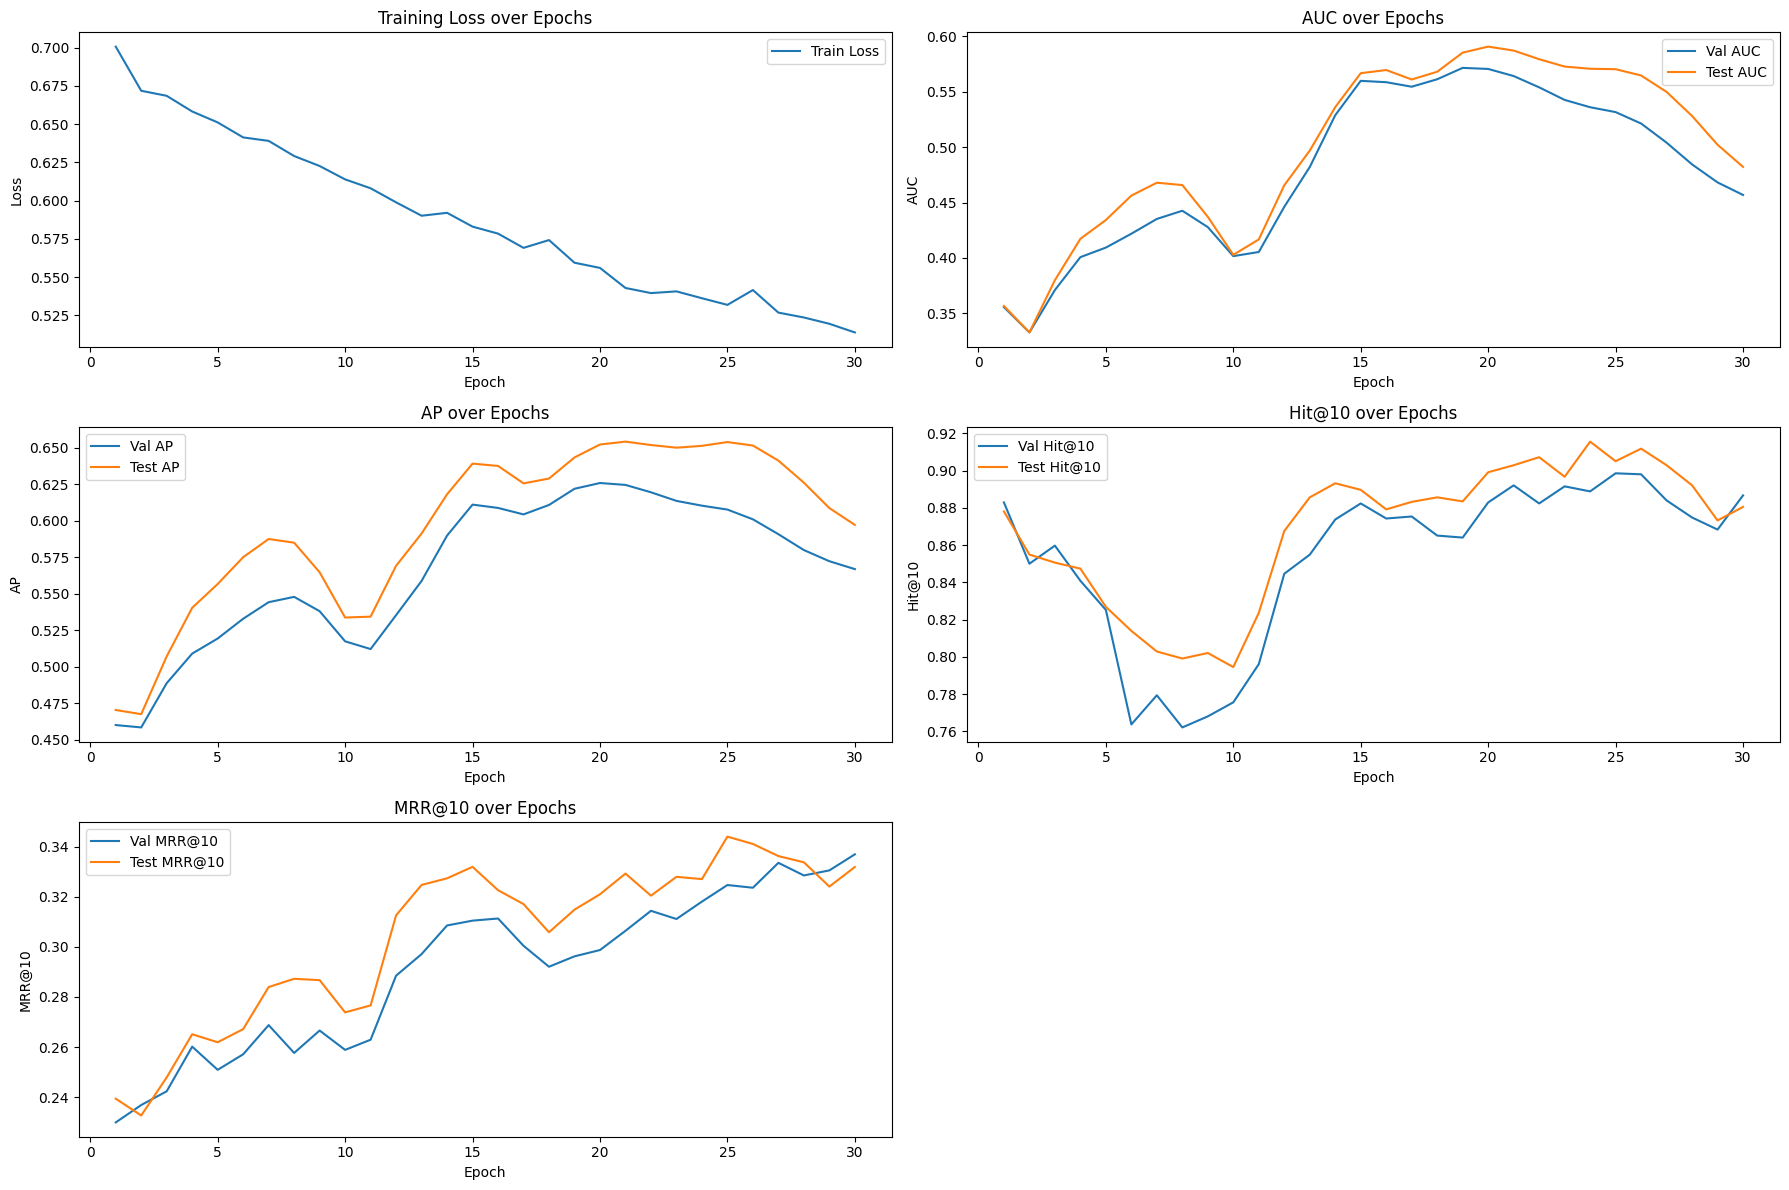

In [80]:
epochs = range(1, len(metrics_history["val_auc"]) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(3, 2, 1)
plt.plot(epochs, metrics_history["loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epochs, metrics_history["val_auc"], label="Val AUC")
plt.plot(epochs, metrics_history["test_auc"], label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC over Epochs")
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(epochs, metrics_history["val_ap"], label="Val AP")
plt.plot(epochs, metrics_history["test_ap"], label="Test AP")
plt.xlabel("Epoch")
plt.ylabel("AP")
plt.title("AP over Epochs")
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epochs, metrics_history["val_hit@10"], label="Val Hit@10")
plt.plot(epochs, metrics_history["test_hit@10"], label="Test Hit@10")
plt.xlabel("Epoch")
plt.ylabel("Hit@10")
plt.title("Hit@10 over Epochs")
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(epochs, metrics_history["val_mrr@10"], label="Val MRR@10")
plt.plot(epochs, metrics_history["test_mrr@10"], label="Test MRR@10")
plt.xlabel("Epoch")
plt.ylabel("MRR@10")
plt.title("MRR@10 over Epochs")
plt.legend()

plt.tight_layout()
plt.show()
